# Working with Data - Computer Lab for Guest Lecture Julia Lane

In this computer lab we will learn more more details and practice data work to enhance the content of the lecture presented by Julia Lane on responsible data use. We will address a research question, think about data and measurement errors, and manipulate data. 

OUTLINE: 
1. Define a research question 
2. Think about what data are available 
3. Think about possible measurement errors 
4. Think about the interpretation of your results 
5. Inform your results by linking datasets 

# 1. Define a reserach question
Which Community Districts in NYC show the highest number of complaints?

# 2. Think about what data are available
Find suitable data by searching the CUSP Data Catalog https://datahub.cusp.nyu.edu/catalog. You can use Urban Profiler to investigate the Metadata associated with each dataset. Using this tool will help you to decide which attributes of the data you need to answer your question so you don't have to load the entire dataset. 

In [1]:
import os
import re
import seaborn
import numpy as np
import pandas as pd
from itertools import cycle
import matplotlib.pyplot as pl
import statsmodels.formula.api as smf
%matplotlib inline

#PUIdata = os.getenv('PUIDATA')
PUIdata = os.environ['DFDATA']
#data = 'https://data.cityofnewyork.us/resource/erm2-nwe9.csv'
data = 'http://cosmo.nyu.edu/~fb55/PUI2016/data/311_Service_Requests_from_2010_to_Present.csv'

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Load dataset
df = pd.read_csv(data, usecols = [0, 23])
df.head()

,Unique Key,Community Board
0,34212771,13 QUEENS
1,34212392,12 BRONX
2,34214520,03 QUEENS
3,34212483,12 BRONX
4,34214231,12 MANHATTAN


# 3. Think about possible measurement errors
Do you see any problems regarding possible measurement error? Think about who is represented in the data, ommissions, duplications, content error, missing data, etc. 

In [3]:
# Check if all Boroughs and Community Districts are represented in the Data
districts = df['Community Board'].unique()
districts

array(['13 QUEENS', '12 BRONX', '03 QUEENS', '12 MANHATTAN',
       '09 MANHATTAN', '08 QUEENS', '01 QUEENS', '07 BRONX', '01 BROOKLYN',
       '03 MANHATTAN', '09 QUEENS', '05 BRONX', '03 BROOKLYN',
       '07 MANHATTAN', '12 BROOKLYN', '0 Unspecified', '09 BROOKLYN',
       '07 QUEENS', '15 BROOKLYN', '08 MANHATTAN', '10 BROOKLYN',
       '08 BROOKLYN', '04 MANHATTAN', '02 MANHATTAN', '12 QUEENS',
       '04 BRONX', '04 BROOKLYN', '01 BRONX', 'Unspecified MANHATTAN',
       '10 QUEENS', '18 BROOKLYN', '11 BROOKLYN', '10 MANHATTAN',
       '11 QUEENS', '16 BROOKLYN', '05 BROOKLYN', '05 MANHATTAN',
       '55 BROOKLYN', '08 BRONX', '09 BRONX', '17 BROOKLYN',
       '01 MANHATTAN', '05 QUEENS', '06 QUEENS', '02 BRONX', '11 BRONX',
       '04 QUEENS', 'Unspecified BROOKLYN', '02 QUEENS',
       '01 STATEN ISLAND', '03 STATEN ISLAND', '14 BROOKLYN',
       '07 BROOKLYN', '02 STATEN ISLAND', '10 BRONX', '11 MANHATTAN',
       '06 BROOKLYN', '13 BROOKLYN', '06 MANHATTAN', 'Unspecified BRONX

In [4]:
# How many unique values do we have? 
len(df['Community Board'].unique())

74

In [5]:
# Why do we have so many? Some of them are unspecified, missing. Some might be invalid entries. 
# We should have 59 Community Districts.
a = '''There are unspecified and invalid community districts in this dataset.'''

In [6]:
# Check for duplicates? Are these plausible?
dups = df.duplicated('Unique Key')
dups.unique() 
a = '''There are no duplicates in this subset of the dataset.'''

In [7]:
# What about missing values? Can you detect any patterns? 
a = '''There are no missing values in this subset of the dataset.'''
df.count()

Unique Key         34897
Community Board    34897
dtype: int64

In [8]:
# Data Editing: Is it possible to replace missing values? Is it possible to use Complaint Type 
# to fill missings in Resolution Descriptor?

In [9]:
# Generate marker for unplausible Community Districts
# How do these districts look like? 
baddistricts = ['Unspecified MANHATTAN', 'Unspecified BROOKLYN', 'Unspecified BRONX', 
            'Unspecified QUEENS', 'Unspecified STATEN ISLAND', '0 Unspecified', 
            '83 QUEENS', '80 QUEENS', '82 QUEENS', '81 QUEENS', '95 STATEN ISLAND', 
            '64 MANHATTAN', '26 BRONX', '27 BRONX', '55 BROOKLYN']

In [10]:
# Drop the marked districts
df1 = df[~df['Community Board'].isin(baddistricts)]
len(df1['Community Board'].unique())

59

In [11]:
# Produce your result: Generate an indicator which ranks the Community District by complaint numbers 
# on the Community district level

# Create Count Summary Table
df2 = pd.DataFrame({'count' : df1.groupby( ['Community Board'] ).size()}).reset_index()

# Regex Community Number
ComNum = []
for row in df2.iterrows():
    ComNum.append(re.findall("(\d+)", row[1][0]))
df2['ComNum'] = [item for sublist in ComNum for item in sublist]

# Regex Community Abbreviation
coms = {'BRONX': 'BX', 'BROOKLYN': 'BK', 'MANHATTAN': 'MN', 'QUEENS': 'QN', 'STATEN ISLAND': 'SI'}
ComAbb = []
for row in df2.iterrows(): 
    for key in coms:
        exp = re.compile(key)
        if re.search(exp, row[1][0]):
            ComAbb.append(coms[key])
df2['ComAbb'] = ComAbb
df2['ID'] = df2['ComAbb'] + df2['ComNum']
df2.drop(df2.columns[2:4], axis = 1, inplace = True)
df2.head()

,Community Board,count,ID
0,01 BRONX,280,BX01
1,01 BROOKLYN,791,BK01
2,01 MANHATTAN,353,MN01
3,01 QUEENS,687,QN01
4,01 STATEN ISLAND,659,SI01


In [12]:
# Safe reduced data frame (Community District level)

# 4. Think about the interpretation of your results?
What do you have to keep in mind when interpreting your results? Are they generable? Does the way the data is collected influence your results? To better inform city agancies it might be good to explore in more detail the underlying dempgraphics/infrastructure of a Community District becasue this might influence 311 calls. You can do this by merging external data on the Community District level to your analysis data. 

In [13]:
# Population by Community District
df_pop = pd.read_csv('http://cosmo.nyu.edu/~fb55/PUI2016/data/Final_Demographics.csv')
df_pop.cd_id = df_pop.cd_id.str[0:4]

In [14]:
# Check variables in file
df_pop.shape

(59, 158)

In [15]:
# How many community districts are in file? 
'''59'''

'59'

In [16]:
# Manipulate data to get some information on demographics by Community District. 
# Think about who might be more likely to call 311
df_pop1 = df_pop[['cd_id', 'Per capita income (In 2014 Inflation Adjusted Dollars)']]
df_pop1.columns = ['ID', 'PerCapitaIncome']
df_pop1.head()

,ID,PerCapitaIncome
0,BX08,30730
1,BX12,21523
2,BX10,28586
3,BX11,22714
4,BX03,12662


In [17]:
# Save data frame

In [18]:
# Infrastructure by Community District
df_infr = pd.read_csv('http://cosmo.nyu.edu/~fb55/PUI2016/data/ACS_Computer_Use_and_Internet_2014_1Year_Estimate.csv')
df_infr.head(2)

,FIPS,Geographic Identifier,Qualifying Name,Households,Households: With An Internet Subscription,Households: Dial-Up Alone,Households: Dsl,Households: With Mobile Broadband,Households: Without Mobile Broadband,Households: Cable Modem,...,Households: Mobile Broadband Alone or With Dialup,Households: Internet Access Without A Subscription,Households: No Internet Access,% Households: With An Internet Subscription,Households.1,Households: Has A Computer,Households: With Dial-Up Internet Subscription Alone,Households: With A Broadband Internet Subscription,Households: Without An Internet Subscription,Households: No Computer
0,3603701,79500US3603701,"NYC-Bronx Community District 8--Riverdale, New...",42035,31795,444,2813,946,1867,19178,...,2168,2119,8121,75.64,42035,35048,404,30943,3701,6987
1,3603702,79500US3603702,"NYC-Bronx Community District 12--Wakefield, Ne...",44830,32243,178,849,405,444,18653,...,928,1891,10696,71.92,44830,36700,178,31435,5087,8130


In [19]:
df_infr.shape

(59, 31)

In [20]:
# Check variables in file
df_infr.describe()

,FIPS,Households,Households: With An Internet Subscription,Households: Dial-Up Alone,Households: Dsl,Households: With Mobile Broadband,Households: Without Mobile Broadband,Households: Cable Modem,Households: With Mobile Broadband.1,Households: Without Mobile Broadband.1,...,Households: Mobile Broadband Alone or With Dialup,Households: Internet Access Without A Subscription,Households: No Internet Access,% Households: With An Internet Subscription,Households.1,Households: Has A Computer,Households: With Dial-Up Internet Subscription Alone,Households: With A Broadband Internet Subscription,Households: Without An Internet Subscription,Households: No Computer
count,5.900000e+01,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,3.603924e+06,58043.254237,43840.508475,198.254237,3360.288136,1123.847458,2236.440678,25573.779661,9229.677966,16344.101695,...,1671.372881,2096.779661,12105.966102,74.383390,58043.254237,48738.559322,187.593220,43105.474576,5445.491525,9304.694915
std,1.522030e+02,15810.303860,16010.775828,138.739969,2007.787640,908.487618,1358.450249,11673.905578,7562.206302,5599.586677,...,1203.374163,916.080501,4194.437844,8.916904,15810.303860,16132.559585,136.414065,16151.874151,2053.307310,3438.676165
min,3.603701e+06,38041.000000,25372.000000,0.000000,301.000000,73.000000,228.000000,10849.000000,1440.000000,5423.000000,...,313.000000,621.000000,4225.000000,57.310000,38041.000000,30869.000000,0.000000,24376.000000,1602.000000,3859.000000
25%,3.603804e+06,46556.000000,32721.000000,88.000000,1670.000000,460.000000,1288.000000,18070.500000,4913.000000,11230.500000,...,964.000000,1474.500000,8821.000000,68.720000,46556.000000,38640.000000,82.000000,31884.000000,3902.000000,6979.000000
50%,3.604003e+06,52641.000000,37464.000000,167.000000,2952.000000,742.000000,1872.000000,22073.000000,6548.000000,15736.000000,...,1385.000000,1882.000000,11465.000000,74.370000,52641.000000,42576.000000,158.000000,37199.000000,5342.000000,8892.000000
75%,3.604018e+06,62605.000000,47837.000000,303.000000,4801.500000,1481.500000,3031.500000,30000.500000,9499.000000,20642.000000,...,1795.000000,2686.500000,15544.000000,80.630000,62605.000000,52873.500000,297.000000,47143.500000,6920.000000,11129.500000
max,3.604114e+06,114838.000000,103065.000000,542.000000,8845.000000,4497.000000,6239.000000,68219.000000,41398.000000,30024.000000,...,6093.000000,5002.000000,22408.000000,90.060000,114838.000000,108746.000000,514.000000,102849.000000,9903.000000,18612.000000


In [21]:
# How many community districts are in file? 
x = len(df_infr['Qualifying Name'].unique())
'There are {} unique entries, some of the community districts are combined into one row'.format(x)

'There are 55 unique entries, some of the community districts are combined into one row'

In [22]:
# Manipulate data to get some information on internet/broadband useage by Community District
# Aggregate the mobile subscription data

# Select subset of columns
df_infr = df_infr[['Qualifying Name', 'Households', 'Households: With Mobile Broadband', 
                  'Households: With Mobile Broadband.1', 'Households: With Mobile Broadband.2',
                 'Households: With Mobile Broadband.3', 'Households: With Mobile Broadband.4']]

# Create summary columns
df_infr['TotalWithMobileBroadband'] = (df_infr['Households: With Mobile Broadband'] + 
                                       df_infr['Households: With Mobile Broadband.1'] + 
                                       df_infr['Households: With Mobile Broadband.2'] + 
                                       df_infr['Households: With Mobile Broadband.3'] + 
                                       df_infr['Households: With Mobile Broadband.4'])
df_infr['TotalPercWithMobileBroadband'] = df_infr['TotalWithMobileBroadband'] / df_infr['Households']
df_infr.drop(df_infr.columns[1:7], axis = 1, inplace = True)
df_infr.head(2)

,Qualifying Name,TotalWithMobileBroadband,TotalPercWithMobileBroadband
0,"NYC-Bronx Community District 8--Riverdale, New...",15359,0.365386
1,"NYC-Bronx Community District 12--Wakefield, Ne...",10486,0.233906


In [23]:
# Aggregate internet type by high and low connections

# Regex Community Number
ComNum = []
for row in df_infr.iterrows():
    ComNum.append(re.findall("(\d+)", row[1][0]))

# Clean rows with representative of 2 community districts
myIterator = cycle(range(2))
for x in ComNum:
    if len(x) > 1:
        del x[myIterator.next()]
df_infr['ComNum'] = [item for sublist in ComNum for item in sublist]
 
# Regex Community Abbreviation
coms = {'Bronx': 'BX', 'Brooklyn': 'BK', 'Manhattan': 'MN', 'Queens': 'QN', 'Staten Island': 'SI'}
ComAbb = []
for row in df_infr.iterrows(): 
    for key in coms:
        exp = re.compile(key)
        if re.search(exp, row[1][0]):
            ComAbb.append(coms[key])
df_infr['ComAbb'] = ComAbb
df_infr['ID'] = df_infr['ComAbb'] + df_infr['ComNum']
df_infr.drop(df_infr.columns[3:5], axis = 1, inplace = True)
df_infr.head()

,Qualifying Name,TotalWithMobileBroadband,TotalPercWithMobileBroadband,ID
0,"NYC-Bronx Community District 8--Riverdale, New...",15359,0.365386,BX8
1,"NYC-Bronx Community District 12--Wakefield, Ne...",10486,0.233906,BX12
2,"NYC-Bronx Community District 10--Co-op City, N...",11425,0.242827,BX10
3,NYC-Bronx Community District 11--Pelham Parkwa...,10748,0.239259,BX11
4,"NYC-Bronx Community District 3 & 6--Belmont, N...",14907,0.259000,BX6


# 5. Inform your results by linking datasets
Now you want to link the three data frames to produce summary statistics for Community Districts which show a high number of complaints vs. Community Districts which show a lower number of complaints. Please keep in mind that the identifiers used for the linkage (Community Dostrict IDs) should be recored the same way. Use regular expressions to harmonize the identifiers if possible. The identifiers should look like BK01, BK02, etc.
https://docs.python.org/2/library/re.html

In [24]:
# Link the 3 dataframes
result = pd.concat([df2, df_pop1, df_infr], axis = 1, join='inner')
result.head(2)

,Community Board,count,ID,ID,PerCapitaIncome,Qualifying Name,TotalWithMobileBroadband,TotalPercWithMobileBroadband,ID
0,01 BRONX,280,BX01,BX08,30730,"NYC-Bronx Community District 8--Riverdale, New...",15359,0.365386,BX8
1,01 BROOKLYN,791,BK01,BX12,21523,"NYC-Bronx Community District 12--Wakefield, Ne...",10486,0.233906,BX12


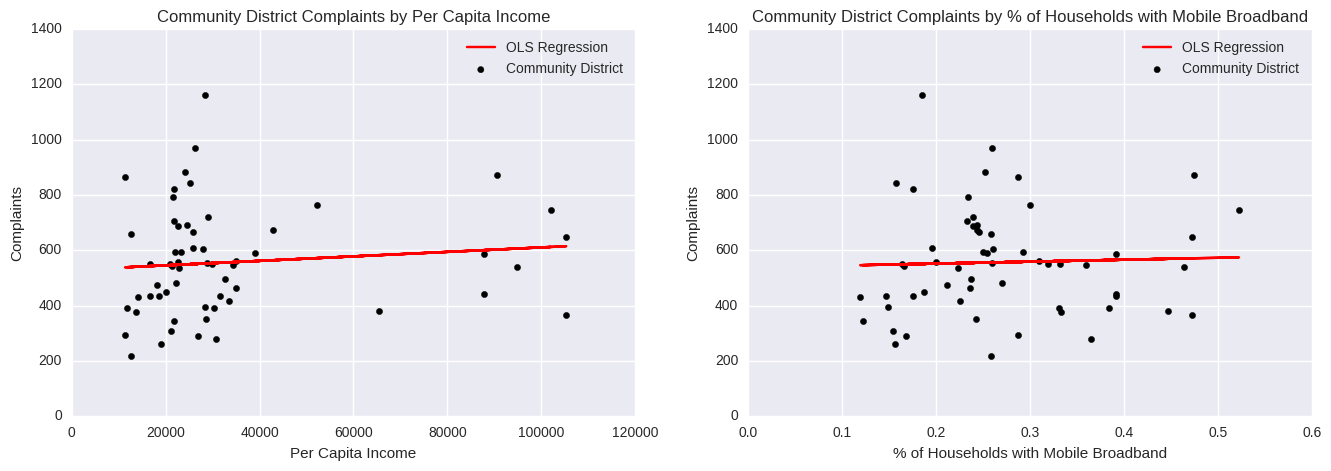

In [25]:
# Are the demographics and infrastructure different in Community Districts that show more complaints than others?
results = smf.ols('count ~ PerCapitaIncome', data = result).fit()
results1 = smf.ols('count ~ TotalPercWithMobileBroadband', data = result).fit()

fig, (ax1, ax2) = pl.subplots(nrows = 1, ncols = 2, figsize = (16,5))

ax1.scatter(result.PerCapitaIncome, result['count'], label = 'Community District', c = 'k')
ax1.plot(result.PerCapitaIncome, results.predict(), c = 'r', label = 'OLS Regression')
ax1.set_xlabel('Per Capita Income')
ax1.set_ylabel('Complaints')
ax1.set_title('Community District Complaints by Per Capita Income')
ax1.legend()

ax2.scatter(result['TotalPercWithMobileBroadband'], result['count'], label = 'Community District', c = 'k')
ax2.plot(result['TotalPercWithMobileBroadband'], results1.predict(), c = 'r', label = 'OLS Regression')
ax2.set_xlabel('% of Households with Mobile Broadband')
ax2.set_ylabel('Complaints')
ax2.set_title('Community District Complaints by % of Households with Mobile Broadband')
ax2.legend()

#### Figure 1.  Community district complaint counts by per capita income & % of households with mobile broadband. In both cases there are appears to be a limited correlation between either per capita income or % of households with mobile broadband and 311 complaints. However, the per capita income does appear to show some linearity that is being overlooked in the regression as a results of extremely wealthy community districts, who may genuinely have fewer complaints.

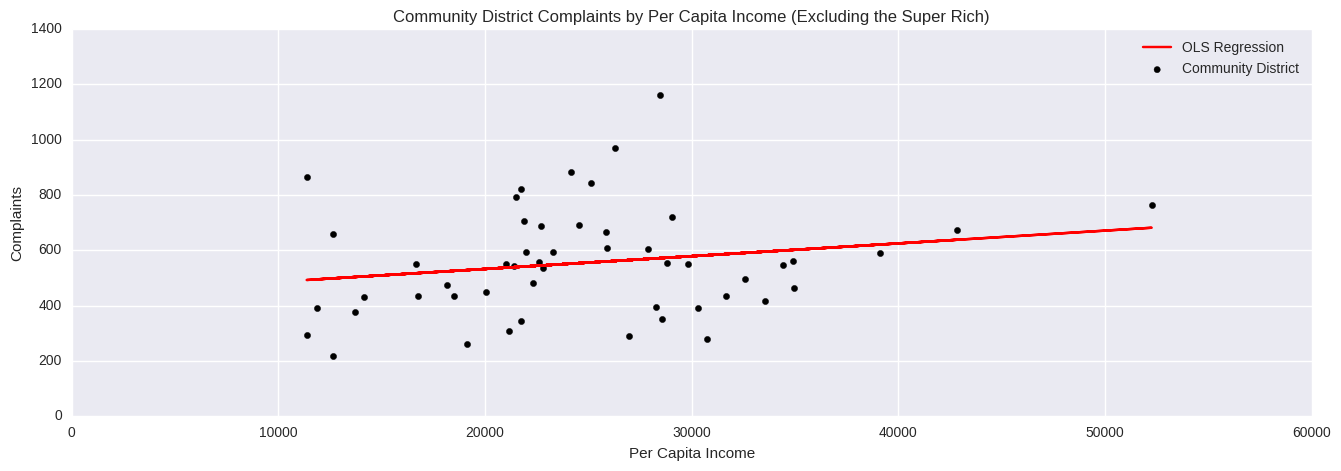

In [26]:
result1 = result.loc[result['PerCapitaIncome'] < 60000]
results2 = smf.ols('count ~ PerCapitaIncome', data = result1).fit()

fig, (ax3) = pl.subplots(nrows = 1, ncols = 1, figsize = (16,5))

ax3.scatter(result1.PerCapitaIncome, result1['count'], label = 'Community District', c = 'k')
ax3.plot(result1.PerCapitaIncome, results2.predict(), c = 'r', label = 'OLS Regression')
ax3.set_xlabel('Per Capita Income')
ax3.set_ylabel('Complaints')
ax3.set_title('Community District Complaints by Per Capita Income (Excluding the Super Rich)')
ax3.legend()

#### Figure 2. Community district complaints by per capita income when exlucing the super rich (>60,000). As illustrated, the per capita income of a community district shows a modest correlation with the amount of 311 complaints.

In [27]:
result.corr()

,count,PerCapitaIncome,TotalWithMobileBroadband,TotalPercWithMobileBroadband
count,1.000000,0.105635,0.085313,0.035705
PerCapitaIncome,0.105635,1.000000,0.868438,0.760617
TotalWithMobileBroadband,0.085313,0.868438,1.000000,0.879789
TotalPercWithMobileBroadband,0.035705,0.760617,0.879789,1.000000


#### Table 1. Correlation table of dataset including all community districts. As expected, there limited correlations between per capita income or % of households with mobile broadband and 311 complaints.

In [28]:
result1.corr()

,count,PerCapitaIncome,TotalWithMobileBroadband,TotalPercWithMobileBroadband
count,1.000000,0.194241,-0.008011,-0.018825
PerCapitaIncome,0.194241,1.000000,0.284909,0.223162
TotalWithMobileBroadband,-0.008011,0.284909,1.000000,0.798054
TotalPercWithMobileBroadband,-0.018825,0.223162,0.798054,1.000000


#### Table 2. Correlation table of data excluding community districts where the per capita income is greater than 60,000. Again as expected, the per capita income shows a modest correlation between per capita income and 311 complaints. 

# Conclusion
#### In conclusion, when using the full dataset of community districts, the amount of 311 complaints would be highest where per capita income and percent of households with mobile broadband is highest. However, when excluding wealthy neighborhoods with per capita income in excess of 60,000, only per capita income correlates positively with 311 complaints.